In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

In [0]:
# Normalize input from [0, 255] to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

In [5]:
# Load data
data = torchvision.datasets.MNIST(root='./dataset', train = True, download=True, transform = transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

0it [00:00, ?it/s]

9920512it [00:02, 4450174.48it/s]                             


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 66282.82it/s]                           
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1106528.91it/s]                            
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 24988.17it/s]            

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    Discriminative network made of three hidden layers that takes a flattened image (of length 28 * 28 = 784) 
    as its input, and returns the probability of it being real or the fake
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    '''
    Flattens an input 2-D image to a 784 length 1-D vector
    '''
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    '''
    Un-flattens the input vector to a 28*28 image
    '''
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    Generative network made of three hidden layers that takes a latent feature vector as input, 
    and returns a vector of size 784 (flattened 28x28 image)
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh() # Maps to a [-1,1] range
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    # Random gaussain noise with mean 0 and stdev 1
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
      return n.cuda() 
    else:
      return n

In [0]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 100

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

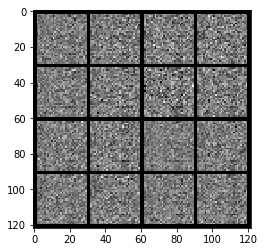

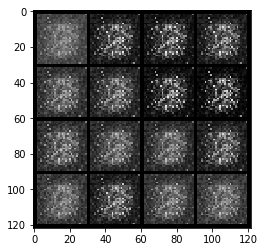

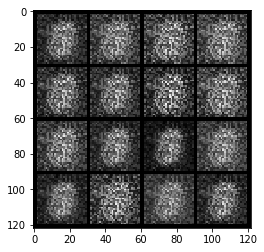

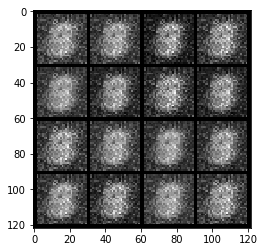

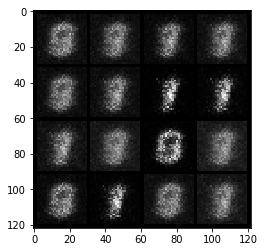

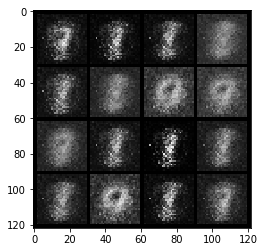

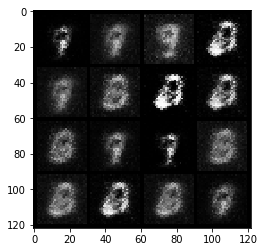

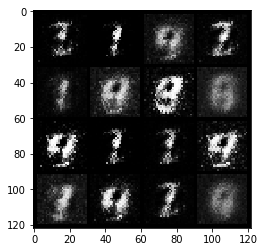

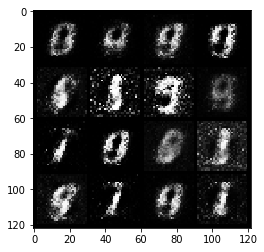

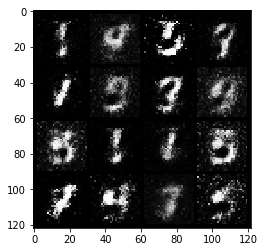

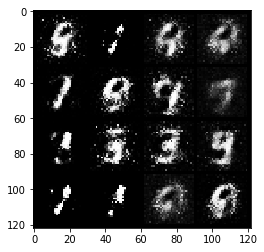

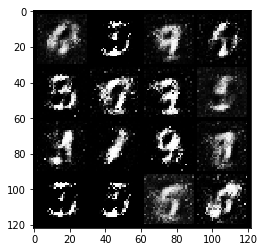

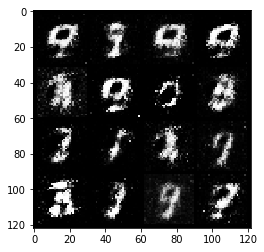

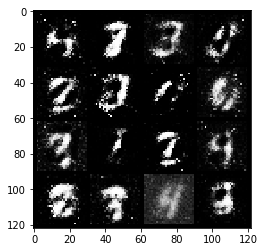

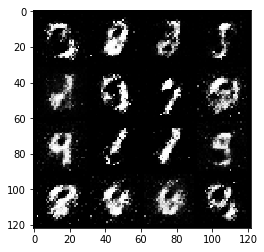

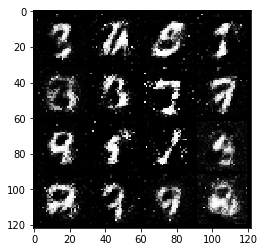

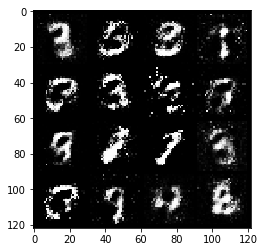

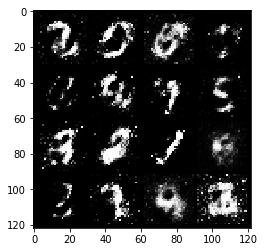

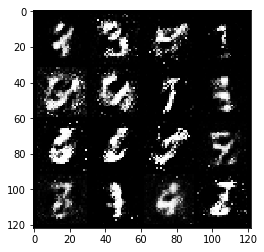

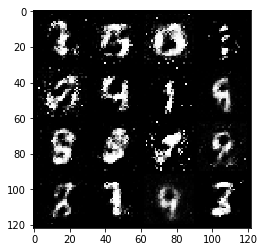

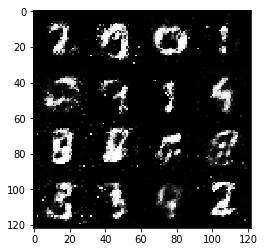

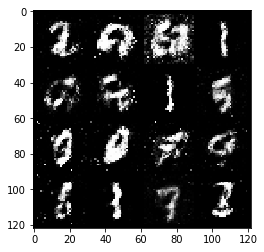

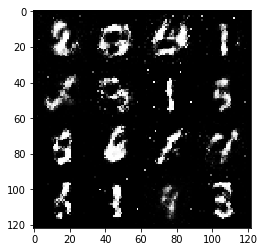

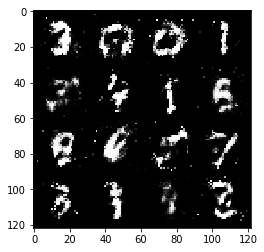

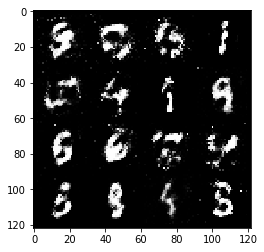

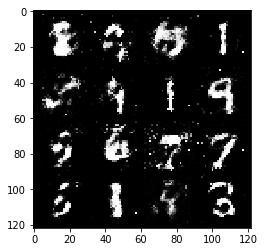

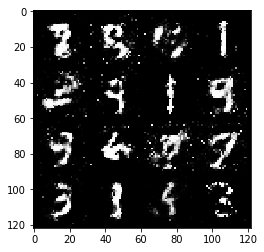

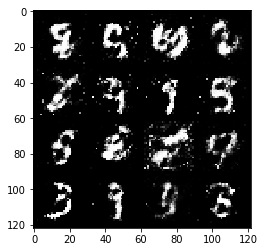

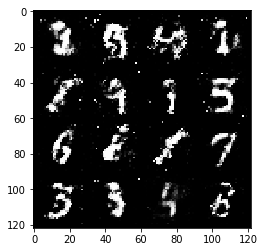

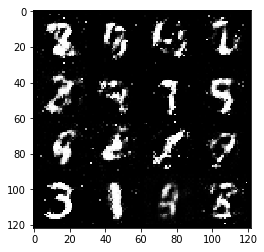

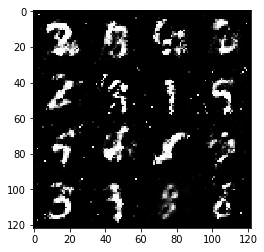

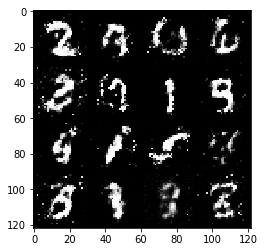

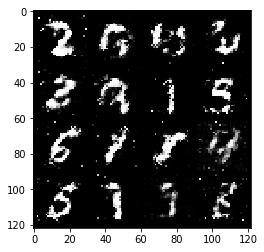

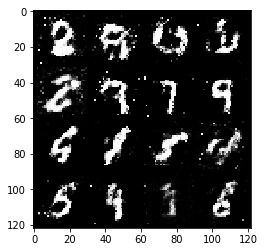

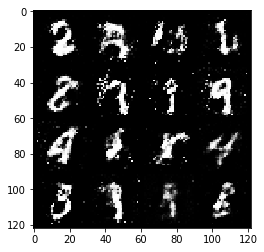

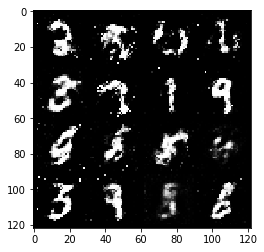

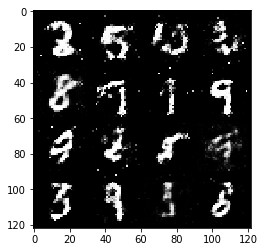

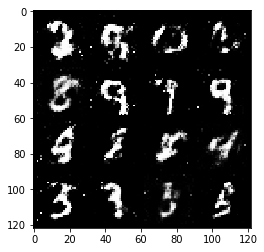

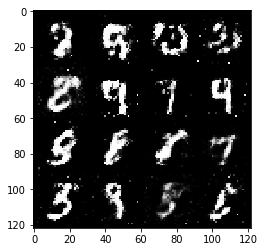

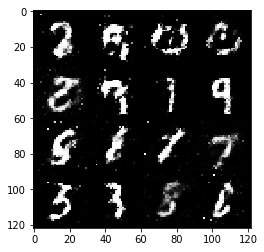

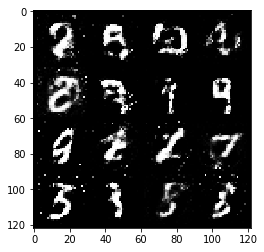

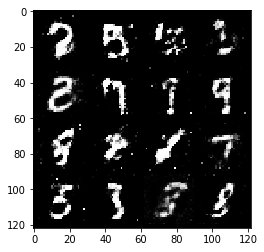

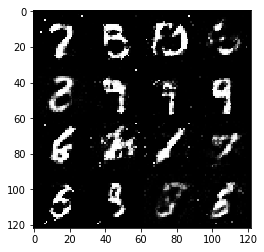

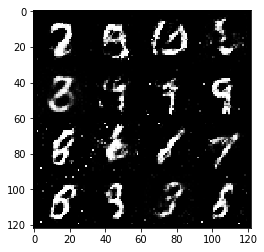

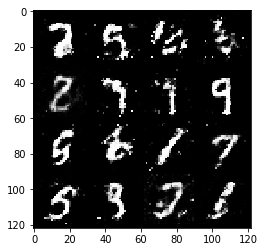

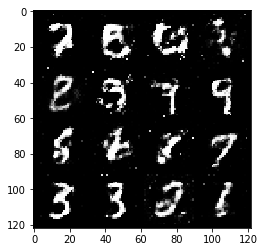

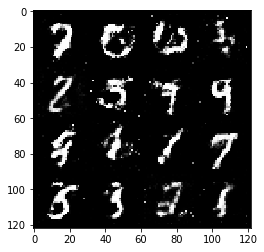

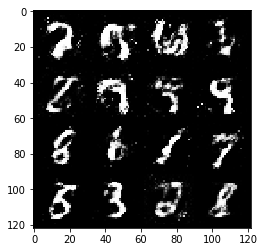

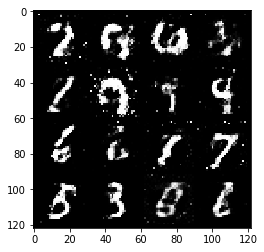

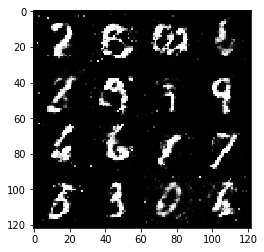

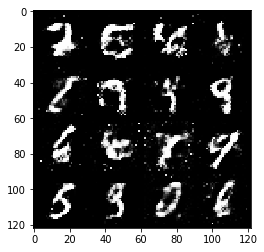

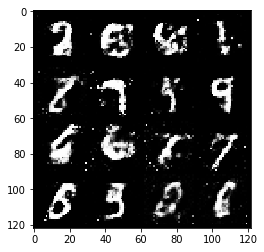

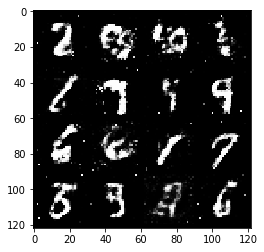

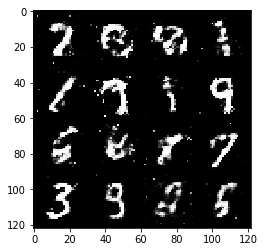

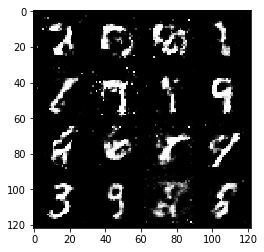

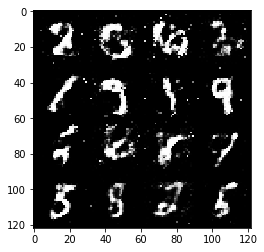

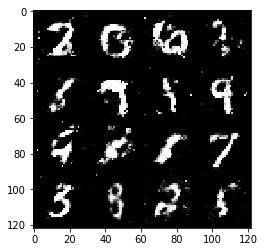

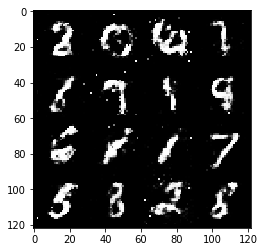

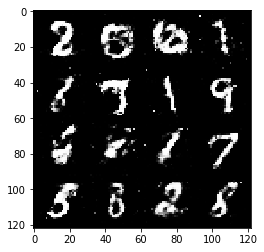

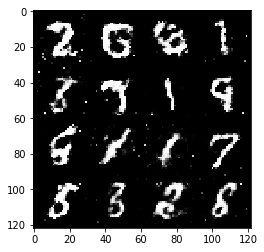

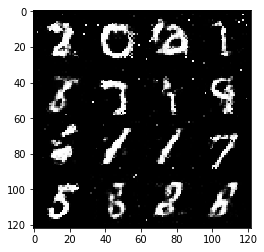

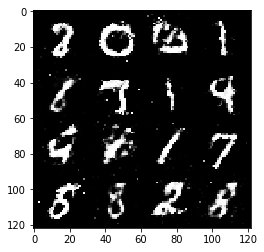

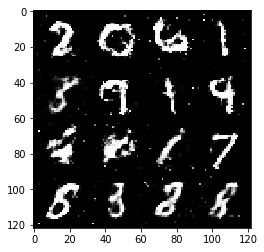

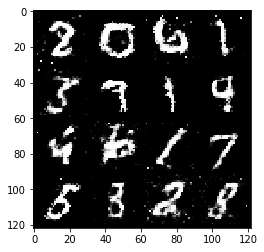

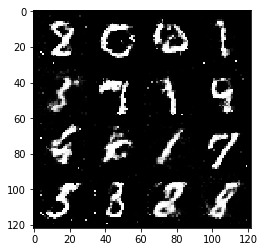

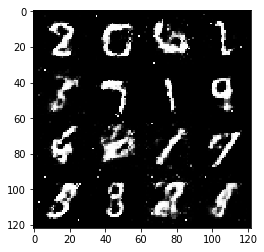

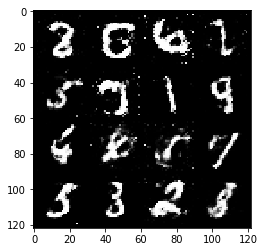

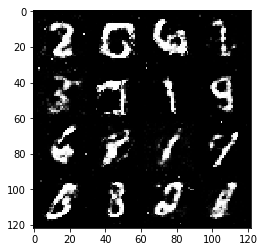

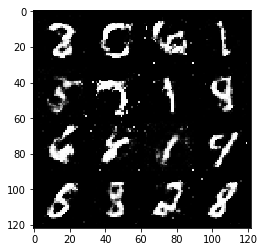

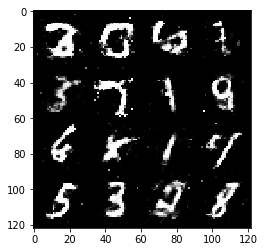

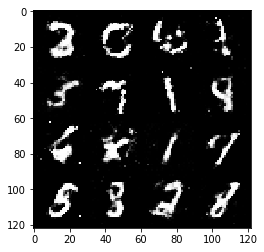

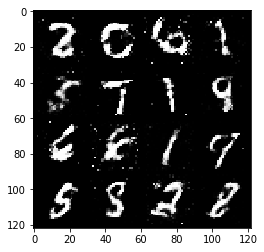

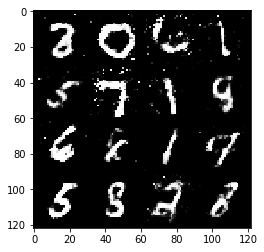

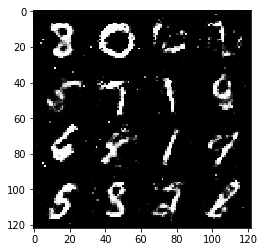

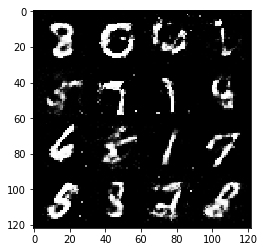

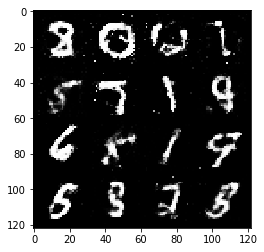

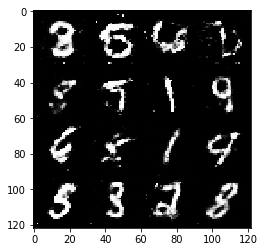

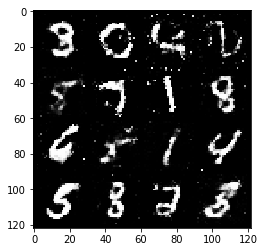

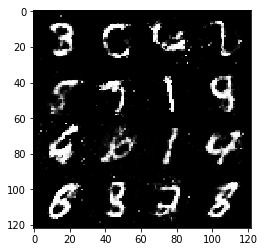

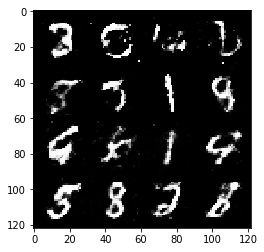

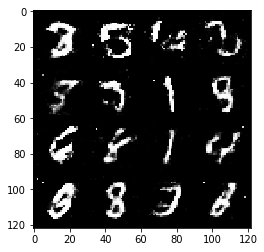

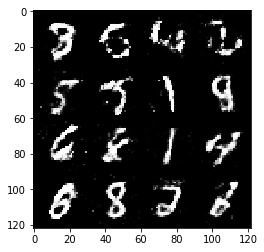

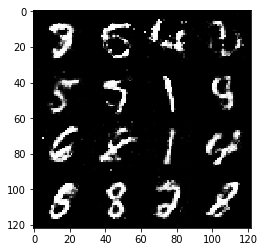

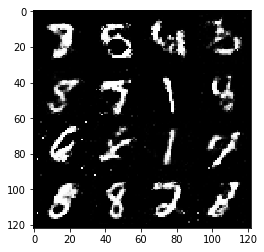

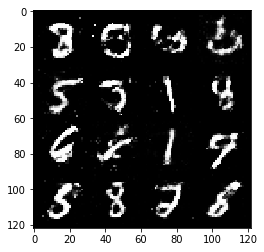

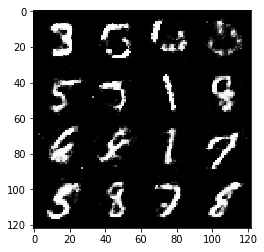

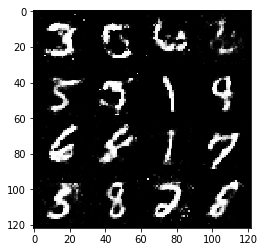

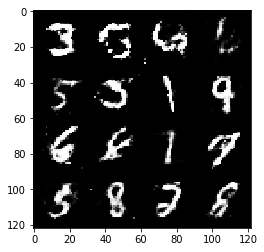

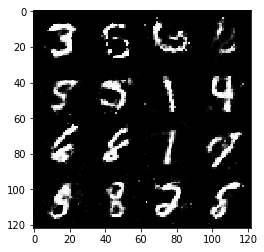

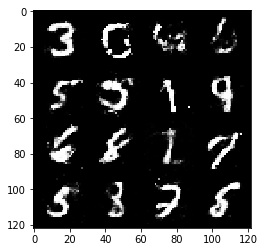

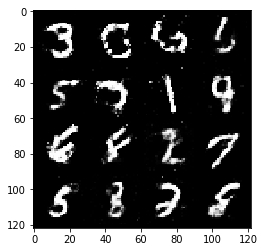

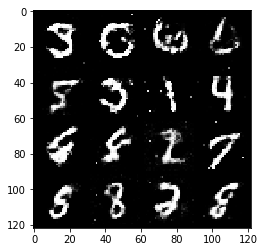

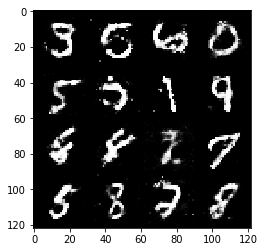

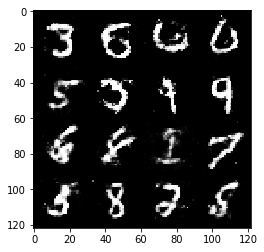

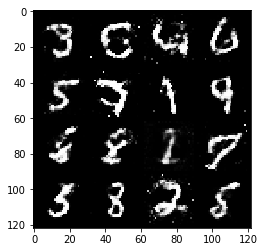

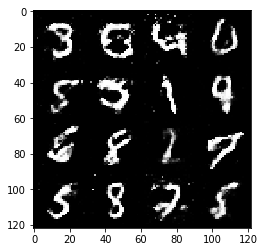

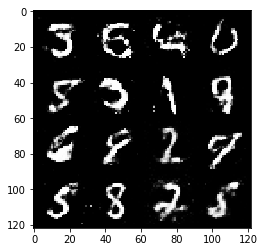

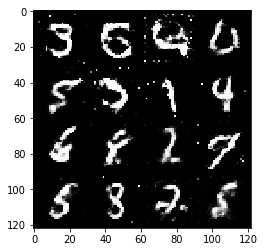

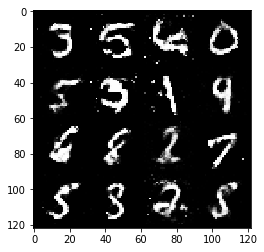

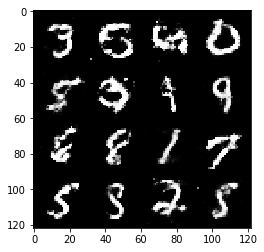

In [13]:
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Discriminator training
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): 
          real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # Generator training
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress
        if (n_batch) % 1000 == 0:
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            
            grid = make_grid(test_images, nrow=4, normalize=True).permute(1,2,0).numpy()
            plt.imshow(grid)
            plt.show()